In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/covid19-face-mask-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_17.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/322.jpg
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_107.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/234.jpg
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_148.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_181.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/260.jpg
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_166.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/66.jpg
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/294.jpg
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/without_mask/image_71.png
/kaggle/input/covid19-face-mask-data/face-mask-dataset/train/with

# **Specify Data Loaders for the Dog Dataset**

 *The code cell below write three separate data loaders for the training, validation, and test datasets of humans images (located at covid19-face-mask-data/face-mask-dataset/train, covid19-face-mask-data/face-mask-dataset/valid, and covid19-face-mask-data/face-mask-dataset/test, respectively). You may find this [documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource. If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!*

In [2]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
from torchvision import datasets

datadir = {

    'train': '../input/covid19-face-mask-data/face-mask-dataset/train/',
    'valid': '../input/covid19-face-mask-data/face-mask-dataset/validation/',
    'test': '../input/covid19-face-mask-data/face-mask-dataset/test'
}

trns_normalize = transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])

transform_transfer = {}
transform_transfer['train'] = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        trns_normalize
    ])
transform_transfer['valid'] = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        trns_normalize
    ])
transform_transfer['test'] = transform_transfer['valid']

# Trying out an idiom found in the pytorch docs
datafolder_transfer = {x: datasets.ImageFolder(datadir[x], transform=transform_transfer[x]) for x in ['train', 'valid', 'test']}

batch_size = 20
num_workers = 0

# Trying out an idiom found in the pytorch docs
loaders_transfer = {x: torch.utils.data.DataLoader(datafolder_transfer[x], batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True) 
for x in ['train', 'valid', 'test']}

# **Model Architecture**
Use transfer learning to create a CNN to classify the face mask breed. Use the code cell below, and save your initialized model as the variable model_transfer.

In [3]:
import torchvision.models as models
import torch.nn as nn


## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False
    
### make changes to final fully collected layers
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [4]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Specify Loss Function and Optimizer
Use the next code cell to specify a loss [function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html). Save the chosen loss function as criterion_transfer, and the optimizer as optimizer_transfer below.

In [5]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

# Train and Validate the Model
Train and validate your model in the code cell below. [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath 'model_transfer.pt'.

In [6]:
import numpy as np
from glob import glob
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        torch.enable_grad()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            # train_loss += loss.item()*data.size(0) # From cifar10_cnn_solution.py
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################
        # validate the model #
        ######################
        model.eval()
        torch.no_grad()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [7]:
# train the model
n_epochs =4 
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


Epoch: 1 	Training Loss: 1.513239 	Validation Loss: 0.381565
Epoch: 2 	Training Loss: 0.299069 	Validation Loss: 0.195738
Epoch: 3 	Training Loss: 0.236393 	Validation Loss: 0.143796
Epoch: 4 	Training Loss: 0.200432 	Validation Loss: 0.127162


<All keys matched successfully>

In [8]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Test the Model**
Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy. Ensure that your test accuracy is greater than 60%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [10]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.118025


Test Accuracy: 97% (254/260)


# Predict if a human is wearing a face mask or not  with the Model
Write a function that takes an image path as input and returns the mask if the man present on the image is wearing a mask  (mask, out mask) that is predicted by your model.

In [11]:
###  Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
class_names = [item[4:].replace("_", " ") for item in datafolder_transfer['train'].classes]
def predict_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path).convert('RGB')
    size = (224, 224) # ResNet image size requirements
    transform_chain = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))
    ])

    img = transform_chain(img).unsqueeze(0)

    if use_cuda:
        img = img.cuda()

    model_out = model_transfer(img)

    if use_cuda:
        model_out = model_out.cpu()
    
    prediction = torch.argmax(model_out)
    
    return class_names[prediction]  # predicted class label

# Write your Algorithm

In [12]:
import matplotlib.pyplot as plt 
def run_app(img_path):
   
    result = predict_transfer(img_path)
    #print(result )
    # display the image, along with bounding box
    if result == " mask" :
        print('cette personne est responsable, il porte son cach nez!!!!!')
    else :
        print('cette personne est  irresponsable, il ne porte pas son cache nez !!!!!')
    img = plt.imread(img_path, 3)
    plt.imshow(img)
    plt.show()


# Test Your Algorithm


cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


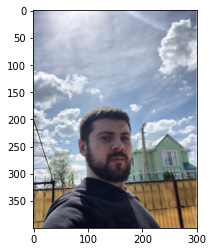

cette personne est responsable, il porte son cach nez!!!!!


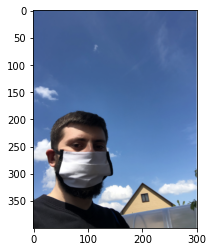

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


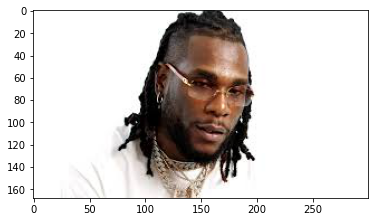

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


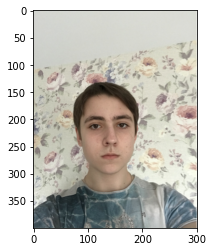

cette personne est responsable, il porte son cach nez!!!!!


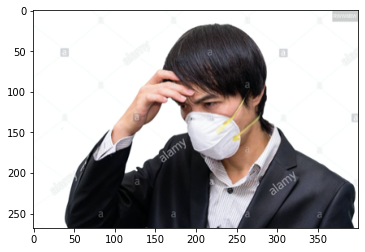

cette personne est responsable, il porte son cach nez!!!!!


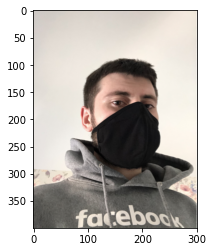

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


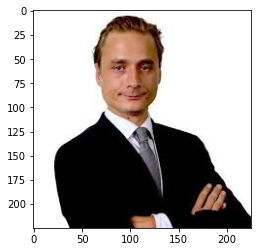

cette personne est responsable, il porte son cach nez!!!!!


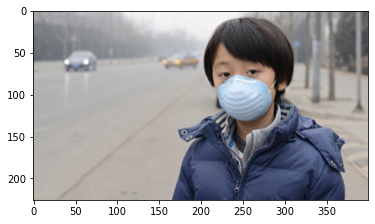

cette personne est responsable, il porte son cach nez!!!!!


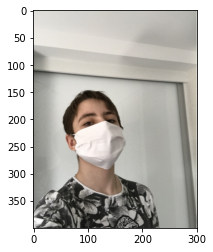

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


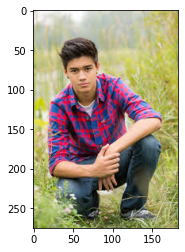

cette personne est responsable, il porte son cach nez!!!!!


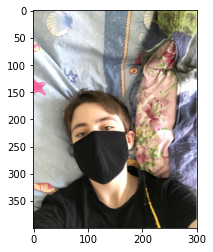

cette personne est responsable, il porte son cach nez!!!!!


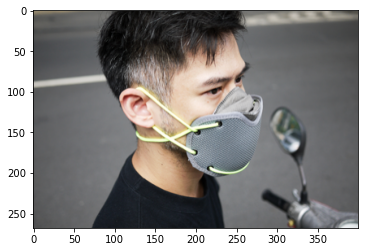

cette personne est responsable, il porte son cach nez!!!!!


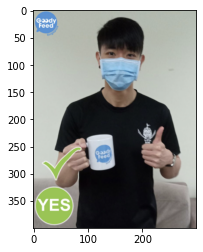

cette personne est responsable, il porte son cach nez!!!!!


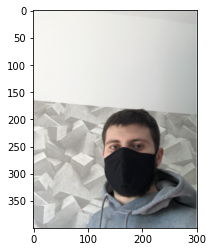

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


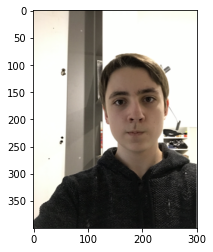

cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


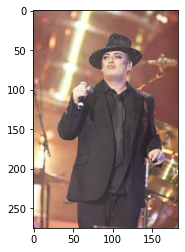

In [13]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below

for file in np.array(glob("../input/covid19-face-mask-recognition-test-data/Covid19-face-mask-recognition-test-data/*")):
    run_app(file)

# step7: optional integrate opencv to the project

In [14]:
import matplotlib.pyplot as plt 
import cv2                                       
%matplotlib inline 
def run_app_with_opencv(img_path):
    # extract pre-trained face detector
    face_cascade = cv2.CascadeClassifier('../input/xmldoc/haarcascade_frontalface_default.xml')

    # load color (BGR) image
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = predict_transfer(img_path)
    # display the image, along with bounding box
    if result == " mask" :
        print("cette personne est responsable, il porte son cach nez!!!!!" )
    else :
        print('cette personne est  irresponsable, il ne porte pas son cache nez !!!!!')

    plt.imshow(cv_rgb)
    plt.show()


cette personne est  irresponsable, il ne porte pas son cache nez !!!!!


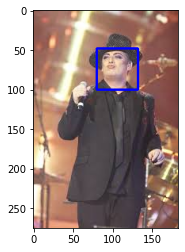

In [15]:
## Execute your algorithm from Step 6 
## on 1 images on your computer.
## Feel free to use as many you want.
for file in np.array(glob("../input/covid19-face-mask-recognition-test-data/Covid19-face-mask-recognition-test-data/4.jpeg")):
    run_app_with_opencv(file)